# Prepare kaggle environment

In order to create a Kaggle environment in Colab, we will need to install the Kaggle library, upload our Kaggle credentials, and download and uncompress the target dataset. Once set up, we will have seamless access to Kaggle datasets and the ability to compete in machine learning competitions./


In [3]:
# Install kaggle library
!pip install kaggle

In [4]:
# Upload kaggle credential
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [5]:
# Prepare kaggle environment
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# decompress dataset
!unzip plantvillage-dataset.zip

Archive:  plantvillage-dataset.zip
replace plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Getting dataset from Exploracion de Datos

In [8]:
import pandas as pd

!git clone https://github.com/deeplearningcourse23/artifacts
dataset_path = "artifacts/transformed_categories.csv"
dataset_df = pd.read_csv(dataset_path)
dataset_df

fatal: destination path 'artifacts' already exists and is not an empty directory.


,CATEGORY,IMAGE_PATH,_merge,CATEGORY_BIN
0,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
1,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
2,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
3,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
4,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
...,...,...,...,...
53533,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy
53534,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy
53535,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy
53536,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy


# Generating labels

In [9]:
from sklearn import preprocessing

# Converting labels from category to numeric
label_encoder = preprocessing.LabelEncoder()
dataset_df["CATEGORY_BIN_ENCODED"] = label_encoder.fit_transform(dataset_df["CATEGORY_BIN"])
dataset_df[["CATEGORY_BIN_ENCODED", "CATEGORY_BIN"]].drop_duplicates()

,CATEGORY_BIN_ENCODED,CATEGORY_BIN
0,1,no healthy
4120,0,healthy


# Defining Preprocessing Stage

In [10]:
import cv2
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import itertools
import more_itertools

# Defining 2 types of preprocessing
# 1. basic_preprocessing: this preprocessing just transform the image and apply a median filter to remove noise
# 2. Applies basic_preprocessing and remove mean from the image

def basic_preprocessing(path):
  target_resolution = (224, 224)
  img_bgr = cv2.imread(path)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  resize_image = cv2.resize(img_rgb, target_resolution)
  denoised_image = cv2.medianBlur(resize_image, 3)
  return denoised_image


def remove_median(path):
    # Retrieve image
    image = basic_preprocessing(path)

    return abs(image - np.median(image))

def scaling(path):
    # Retrieve image
    image = basic_preprocessing(path)
    image_center = image.astype(np.float) - np.median(image)
    max = image_center.max()
    min = image_center.min()
    factor = 1/(max - min)
    processed = factor * image_center
    return processed

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, function, scaling = 255.0):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.function = function
        self.indexes = np.arange(len(self.image_paths))
        self.scaling = scaling

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_image_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        batch_images = [self.function(image_path) for image_path in batch_image_paths]
        batch_images = np.array(batch_images) / self.scaling  # Normalize pixel values

        return batch_images, np.array(batch_labels)

# Defining training model class

In [12]:
def get_weights(y):
    total = len(y)
    total_1 = len(dataset_df[dataset_df["CATEGORY_BIN_ENCODED"] == 1])
    total_0 = total - total_1
    weight_1 = total_1 / total
    weight_0 = total_0 / total
    class_weight = {0: weight_0, 1: weight_1}
    return class_weight

In [14]:
# Splitting dataframe columns into features
y, x = dataset_df["CATEGORY_BIN_ENCODED"], dataset_df["IMAGE_PATH"]

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

class ExperimentSetUp():
    def __init__(self, x, y, function, scaling):
        self.img_size = (224, 224)
        self.channels = 3
        self.batch_size=32
        self.img_shape = (self.img_size[0], self.img_size[1], self.channels)
        self.class_count = 1
        self.x = x
        self.y = y
        self.function = function
        self.scaling = scaling
        self.epochs = 1

    def prepare_model(self):
        base_model = tf.keras.applications.resnet50.ResNet50(
        include_top=True, weights='imagenet', input_tensor=None,
        input_shape=None, pooling="max", classes=1000)
        self.model = Sequential([
            base_model,
            BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
            Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                        bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
            Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                        bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
            Dropout(rate= 0.45, seed= 123),
            Dense(self.class_count, activation= 'sigmoid')
        ])

        self.model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

        self.model.summary()

    def split_test_train(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.x,
            self.y,
            stratify=self.y,
            test_size=0.15
        )
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def model_training(self):
        self.train_data = CustomDataGenerator(
                self.X_train,
                self.y_train,
                self.batch_size,
                self.function,
                self.scaling
            )
        self.val_data = CustomDataGenerator(
                self.X_test,
                self.y_test,
                self.batch_size,
                self.function,
                self.scaling
            )
        self.history = self.model.fit(
            self.train_data,
            epochs= self.epochs,
            verbose=1,
            validation_data= self.val_data,
            validation_steps= None,
            shuffle= False,
            class_weight=get_weights(self.y)
        )



In [36]:
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

def printMetrics(ytrue, y_pred_th):
  CLASS_NAMES = ["Healthy", "No Healthy"]

  acc = accuracy_score(ytrue, y_pred_th)
  cm = tf.math.confusion_matrix(ytrue, y_pred_th)
  clr = classification_report(ytrue, y_pred_th, target_names=CLASS_NAMES)

  print("Test Accuracy: {:.3f}%".format(acc * 100))

  plt.figure(figsize=(3, 3))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES, rotation=90)
  plt.yticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print(clr)


def get_test_metrics(processor):
  y_pred = processor.model.predict(processor.val_data)
  y_pred_th = (y_pred > 0.5).astype(float)

  ytrue = []

  for batch_id in range(len(processor.val_data)):
    [ytrue.append(value) for value in processor.val_data[batch_id][1]]

  ytrue = np.array(ytrue).astype(float)

  return ytrue, y_pred_th

def experimentSetUp(x, y, function, scaling):
  processor = ExperimentSetUp(x, y, function, scaling)

  processor.prepare_model()
  processor.split_test_train()
  processor.model_training()

  ytrue, y_pred_th = get_test_metrics(processor)
  printMetrics(ytrue, y_pred_th)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization_1 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               256256    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

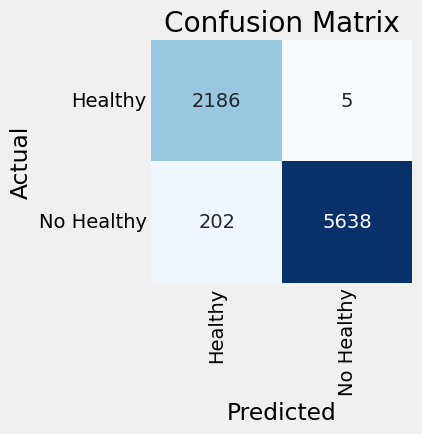

              precision    recall  f1-score   support

     Healthy       0.92      1.00      0.95      2191
  No Healthy       1.00      0.97      0.98      5840

    accuracy                           0.97      8031
   macro avg       0.96      0.98      0.97      8031
weighted avg       0.98      0.97      0.97      8031



In [37]:
experimentSetUp(x, y, function=basic_preprocessing, scaling=255.0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization_2 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               256256    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                      

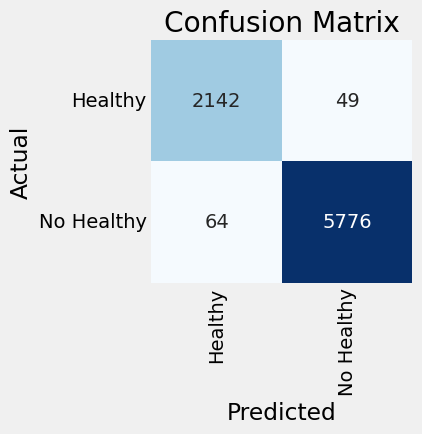

              precision    recall  f1-score   support

     Healthy       0.97      0.98      0.97      2191
  No Healthy       0.99      0.99      0.99      5840

    accuracy                           0.99      8031
   macro avg       0.98      0.98      0.98      8031
weighted avg       0.99      0.99      0.99      8031



In [38]:
experimentSetUp(x, y, function=remove_median, scaling=255.0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization_3 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               256256    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                      

<ipython-input-10-2951f9ab1925>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_center = image.astype(np.float) - np.median(image)


251/251 [==============================] - 42s 165ms/step
Test Accuracy: 98.120%


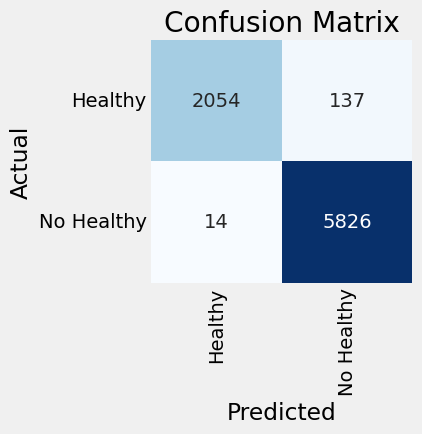

              precision    recall  f1-score   support

     Healthy       0.99      0.94      0.96      2191
  No Healthy       0.98      1.00      0.99      5840

    accuracy                           0.98      8031
   macro avg       0.99      0.97      0.98      8031
weighted avg       0.98      0.98      0.98      8031



In [39]:
experimentSetUp(x, y, function=scaling, scaling=1.0)